# **Taskifier - Intelligent Task Allocation & Management**

## Tech Stack
* Langchain
* LangGraph
* Tavily

## Overview

Taskifier presents an agent that helps manage task management for productivity optimization. This tutorial utilizes Langchain and LangGraph to build a regulated pipeline for such purpose. It encompasses: 
 - context breakdown & analysis
 - external resource retrieval (web search)
 - discretization of information

## Motivation

In the world of workforce, procrastination and messy workflow is a common phenomenon, particularly with college students or non-administration level personnel in workplace. This is often due to the lack of clarity in objectives with the tasks given to them. Suppose a SWE in a startup was given a task to build a sign-in page for a web app. Things get messy and discouraging when the SWE was trying to start coding and asked questions like, "should I build an auth server first or should I create the front end first?". Those questions can branch off to smaller sub-questions, leaving the task puzzling and therefore driving procrastination. This phenomenon is highly replicable across different industries as well.

This projects aim at assisting in the analysis and organization of tasks that users need to complete. It utilizes the LLM's ability to qualitatively dissect information for such purpose. It will involve some behavioral analysis that adjusts the workstyle according to underlying patterns of how users approach different tasks, and thereby return an optimal workflow suggestion.

## Key Components

1. Data Ingestion: Gathers data for approach analysis
2. State Graph: Orchestrates steps from analysis to personalized generation
3. Tavily Web Query: Searches for information on the task to maximize task proficiency
4. LLM Model: Generates plans and analyzes approach

## Method Details

The system follows a step-by-step approach to personalize approaching plan for queried task:
1. Approach Analysis: Breakdown how the user tends to carry out tasks (a step by step person? a plan-first-then-build approach?)
2. Information Gathering: Retrieval of information related to the task in virtue of understanding what is necessary for completing the task
3. Customized Approach Generation: Given the analyzed style, the LLM generates a customized approach according to the style. 

## Program Visualization

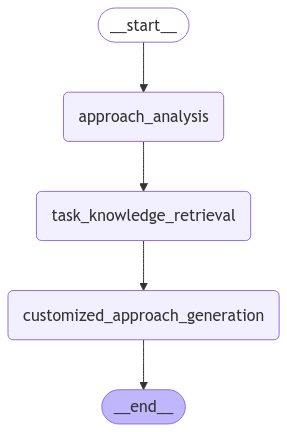

In [8]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

## Conclusion

This notebook exhibits the organized pipeline using LangGraph to induce step by step breakdown and generation of optimal response based on the user's preferences. It enables potential applications across different fields and different characters to optimize their workflow and productivity. Further analysis involving quantitative analysis can be used but given time limitation, we let LLM tackle the analysis of approach and yield the complete plan accordingly. Future improvements can involve behavioral analysis of decision making in quantitative terms, having multiple personas of different work attitudes and approach styles and match the user's preferences to the most similar personas, pivoting from user's feedbacks on generated response and tuning the style preference accordingly, etc.

***

## Installation
We will be using LangChain & LangGraph for building ensembles of agents & controlling their workflow.

In [1]:
%%capture --no-stderr
!pip install langchain langgraph tavily-python

## Importations
**Make sure you have the OpenAI and Tavily API Keys as part of your environment variables!**

In [2]:
import os
from typing import TypedDict, Annotated, List
from langgraph.graph import START, StateGraph, END

from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langchain_openai import ChatOpenAI
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image, Markdown

from tavily import TavilyClient

import os
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')
os.environ["TAVILY_API_KEY"] = os.getenv('TAVILY_API_KEY')

## State Definitions
Here we define the states for the agent workflow. The states w

In [3]:
class ApproachState(TypedDict):
    plan: str  # detailed workflow of the approach
    style: str # style description of the approach
    task: str # user's input of task
    details: str # internet retrieval of task specs
    history: str # description of history approaches

## LLM & Tavily Initialization

In [4]:
# Initialize the ChatOpenAI model
llm = ChatOpenAI(model="gpt-4o-mini")
tavily_client = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

## Component Functions
Define functions for...
* Internet Query of Task Specs [retrieval]
* Compare User Approach Preference vs Personas Approach Preference [filter approach]

In [5]:
from tavily import TavilyClient

def approach_analysis(approach: ApproachState) -> ApproachState:
    """Retrieve history approach and let LLM do a qualitative analysis on user approach preference."""
    history = ""
    for h in os.listdir(f"{os.getcwd()}/history"):
        if (h[-4:] == ".txt"):
            with open(os.path.join(os.getcwd(), f"history/{h}")) as f:
                content = f.readlines()
            history = f"{history}\n{content[0]}"

    approach['history'] = history

    prompt = ChatPromptTemplate.from_template(
        "Analyze the work style the following summary of work history portrays. "
        "Provide a brief summary the preference in work style."
        "\n\nWork History: {history}"
    )
    style = llm.invoke(prompt.format(history=approach['history']))
    approach['style'] = style
    return approach

# def extract_aim(approach: ApproachState) -> ApproachState:
#     """Get key aims from the task query."""

def task_manifest(approach: ApproachState) -> ApproachState:
    """use Tavily to look up information on the task."""

    search_foundation = "What are the steps for the following task? {task}"
    search_query = search_foundation.format(task=approach["task"])
    
    searches = tavily_client.search(search_query, max_results=10)

    details = ""

    for result in searches['results']:
        if details == "":
            details = result['content']
        else:
            details = f"{details} {result['content']}"

    approach["details"] = details

    return approach

def result_approach(approach: ApproachState) -> ApproachState:
    prompt = ChatPromptTemplate.from_template(
        "Give me a plan of steps to carry out the following task with custom work styles specified."
        "You have to pay extra attention to Work Style mentioned below and adjust the plan accordingly."
        "\n\nTask: {task}\n\nDetails: {details}\n\nWork Style: {style}\n\n"
        "The output must be a numbered list of steps with explanation of why it is needed, what to do and how it considers the Work Style."
    )

    suggestion = llm.invoke(prompt.format(task=approach["task"], details=approach["details"], style=approach["style"]))

    approach['plan'] = suggestion

    return approach

## Graph Workflow Building
Now we can start to structure the workflow and organize them in order!

In [6]:
# Initialize the StateGraph
workflow = StateGraph(ApproachState)

# Add nodes to the graph
workflow.add_node("approach_analysis", approach_analysis)
workflow.add_node("task_knowledge_retrieval", task_manifest)
workflow.add_node("customized_approach_generation", result_approach)

# Define and add conditional edges
workflow.add_edge("approach_analysis", "task_knowledge_retrieval")
workflow.add_edge("task_knowledge_retrieval", "customized_approach_generation")

# Set the entry point
workflow.set_entry_point("approach_analysis")

# Set the exit point
workflow.add_edge("customized_approach_generation", END)

# Compile the graph
app = workflow.compile()

## Agent Calling Function
This function will be used to induce the entire workflow!

In [7]:
def approach(task: str) -> ApproachState:
    init_approach = ApproachState(
        task=task,
        plan="",
        style="",
        history="",
        details=""
    )

    response = app.invoke(init_approach)
    return response

### **🚀🚀🚀🚀🚀🚀🚀🚀 Great! Now we can start the inference and see how the workflow performs! 🚀🚀🚀🚀🚀🚀🚀🚀**

## Example
This is an example where the user hopes to build a smoke detector that is futuristic in design and accessible for installation!

In [32]:
query = """
    I want to build a smoke detector device! I am visioning it with futuristic design and hope to maximize the ability to install it anywhere. Perhaps keep it small and energy efficient for that purpose!
    """

## Some history is being fed into the Agent! It helps the agent understand users' approach preferences!
generated_plan = approach(task=query)


print(f"Task:\n")
print(f"{generated_plan['task']}\n")
print(f"Style:\n")
print(f"{generated_plan['style']}\n")
print(f"Steps:\n")
generated_plan['plan'].pretty_print()

Task:


    I want to build a smoke detector device! I am visioning it with futuristic design and hope to maximize the ability to install it anywhere. Perhaps keep it small and energy efficient for that purpose!
    

Style:

content="The work history summary portrays a systematic and pragmatic work style. The individual demonstrates a preference for tackling tasks in a structured manner, starting with simpler challenges to build confidence and familiarity before progressing to more complex issues. This approach reflects a methodical mindset and a desire to establish a strong foundation before confronting difficulties.\n\nIn the context of their venture into the medical IT field, the individual shows a proactive attitude by prioritizing regulatory challenges from the FDA and EMA, indicating a preference for addressing potential obstacles early on to avoid complications later. This indicates a forward-thinking approach and an inclination to mitigate risks.\n\nWhen it comes to job applic